# SNN

--------------------------
## Personal
#### Things to Do:
- (DONE) L2 normalisation gives slower training so that line has been commented out.Need to figure out why that's happening and if it is normal
- (DONE) Implement modified softmax
- (DONE) Combine DenseNet and Modified Softmax
- Figure out class weights and incorporate that
- check if alpha needs a relu (only with actual embeddings)
- (DONE)Batching the training
- (DONE)Logging information nicely
- (DONE)Write out embeddings into a file for all the profiles
--------------------------

## Resources and Information

Additive margin loss: https://arxiv.org/pdf/1801.05599.pdf
<br>Large margin softmax: https://arxiv.org/pdf/1612.02295.pdf https://github.com/auroua/L_Softmax_TensorFlow/blob/master/nets/l_softmax.py

--------------------------

## Code
--------------------------

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.datasets import mnist
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import math
import sys
from sklearn.model_selection import train_test_split

/home/kavya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### MNIST Data

In [15]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 784)
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], 784)
x_train_mnist = x_train_mnist.astype('float32')
x_test_mnist = x_test_mnist.astype('float32')
x_train_mnist /= 255
x_test_mnist /= 255

data_size = 5000

X_mnist = x_train_mnist[:data_size]
y_mnist = y_train_mnist[:data_size]

y_onehot_mnist = np.zeros([data_size, 10])
y_onehot_test_mnist = np.zeros([len(y_test_mnist), 10])

for a in range(data_size):
    y_onehot_mnist[a][y_mnist[a]] = 1
for a in range(len(y_test_mnist)):
    y_onehot_test_mnist[a][y_test_mnist[a]] = 1

### Network Parameters

In [101]:
input_size = 28*28
n_layers = 10
n_classes = 10
n_units = 20
batch_size = 50
epochs = 80
learning_rate = 0.05

### Accuracy Function

In [49]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

### Neural Network

In [115]:
tf.reset_default_graph()

number_of_units_nn = 20

inputs = tf.placeholder(tf.float32, [None, input_size])
original_input = inputs
labels = tf.placeholder(tf.int32, [None])
onehot_label = tf.one_hot(labels, n_classes, name='labels_onehot')

for a in range(n_layers):
    layer = tf.layers.dense(inputs, number_of_units_nn, 'selu', name='layer'+str(a))
    inputs = layer

logits = tf.layers.dense(inputs, n_classes, None, name='output')
logits = tf.math.l2_normalize(logits, axis=1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=onehot_label))

predictions = tf.nn.softmax(logits)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

with tf.Session() as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    nn_loss = []

    for a in range(epochs):
        _, l, p = session.run([optimizer, loss, predictions], 
                              feed_dict={original_input:X_mnist, labels:y_mnist})
        nn_loss.append(l)

        if a%10==0:
            print("Epoch:", a+1, "\tLoss:", l, "\tAccuracy:", accuracy(p, y_onehot_mnist))

    test_p = session.run(predictions, feed_dict={original_input:x_test_mnist, labels:y_test_mnist})

    print("Test Accuracy: ", accuracy(test_p, y_onehot_test_mnist))

    
    tf.summary.FileWriter('./logs', session.graph)

Initialized
Epoch: 1 	Loss: 2.372304 	Accuracy: 11.02
Epoch: 11 	Loss: 2.0812314 	Accuracy: 33.98
Epoch: 21 	Loss: 1.9506289 	Accuracy: 42.7
Epoch: 31 	Loss: 1.8882558 	Accuracy: 43.34
Epoch: 41 	Loss: 1.8369068 	Accuracy: 47.56
Epoch: 51 	Loss: 1.8022531 	Accuracy: 50.0
Epoch: 61 	Loss: 1.7814133 	Accuracy: 51.5
Epoch: 71 	Loss: 1.783635 	Accuracy: 49.22
Test Accuracy:  60.8


---------------------
### Dense Network with Softmax on Onehot Encoding
![title](img/densenet.png)

In [117]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, input_size])
original_input = inputs
labels = tf.placeholder(tf.int32, [None])

for a in range(n_layers):
    layer = tf.layers.dense(inputs, n_units, 'selu', name='layer'+str(a))
    inputs = tf.concat([inputs, layer], 1, name='concatenation'+str(a))

logits = tf.layers.dense(inputs, n_classes, None, name='output')
logits = tf.math.l2_normalize(logits, axis=1)

onehot_label = tf.one_hot(labels, n_classes, name='labels_onehot')
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=onehot_label))

predictions = tf.nn.softmax(logits)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

### Running the Network

In [118]:
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    dnn_loss = []

    for a in range(epochs):
        _, l, p = session.run([optimizer, loss, predictions], 
                              feed_dict={original_input:X_mnist, labels:y_mnist})
        dnn_loss.append(l)
        if a%20==0:
            print("Epoch:", a+1, "\tLoss:", l, "\tAccuracy:", accuracy(p, y_onehot_mnist))

    test_p = session.run(predictions, feed_dict={original_input:x_test_mnist, labels:y_test_mnist})

    print("Test Accuracy: ", accuracy(test_p, y_onehot_test_mnist))

    
    tf.summary.FileWriter('./logs', session.graph)

Initialized
Epoch: 1 	Loss: 2.3720586 	Accuracy: 8.28
Epoch: 21 	Loss: 1.486958 	Accuracy: 94.06
Epoch: 41 	Loss: 1.4444349 	Accuracy: 97.76
Epoch: 61 	Loss: 1.4347043 	Accuracy: 98.62
Test Accuracy:  92.95


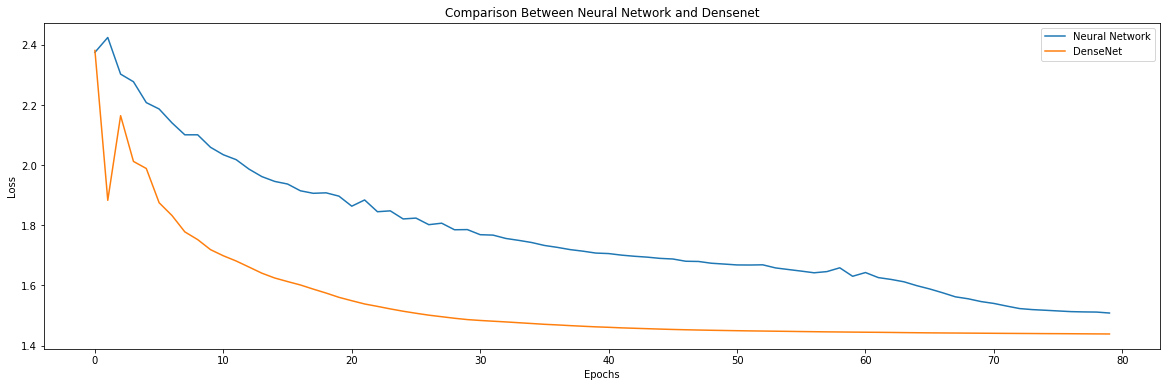

In [108]:
plt.figure(figsize=(20, 6))
plt.plot(np.arange(epochs), nn_loss, label='Neural Network')
plt.plot(np.arange(epochs), dnn_loss, label='DenseNet')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Comparison Between Neural Network and Densenet")
plt.show()

-----------------
### Modified Softmax Function
![title](img/modified_softmax.png)

In [8]:
embedding_length = 12
number_of_samples = 22
number_of_classes = 27

tf.reset_default_graph()

labels = tf.placeholder(tf.int32, [None], name='labels')

embeddings = tf.placeholder(tf.float32, [None, embedding_length])
norm_embeddings = tf.nn.l2_normalize(embeddings, axis=1, name='embeddings')

class_weights = tf.constant(normalize(np.random.rand(embedding_length, number_of_classes)), dtype=tf.float32,
                           name='class_weights')

margin = tf.placeholder(tf.float32, name='margin')

alpha_initial = tf.get_variable(dtype=tf.float32, initializer=tf.constant(np.random.rand(1), dtype='float32'), name='alpha')
alpha = tf.nn.relu(alpha_initial)

cosines = tf.matmul(norm_embeddings, class_weights, name='cosines')
onehot_label = tf.one_hot(labels, number_of_classes, name='labels_onehot')
m_onehot = tf.math.multiply(margin, onehot_label, name='mxonehot')
margin_cosine = tf.subtract(cosines, m_onehot, name='cosine-m')
alpha_margin_cosine = tf.math.exp(tf.math.multiply(alpha, margin_cosine), name='alphaxc-m')
amc_numerator = tf.reduce_sum(tf.multiply(alpha_margin_cosine, onehot_label), axis=1, name='amc_positive')
amc_denominator = tf.reduce_sum(alpha_margin_cosine, axis=1, name='amc_total')
amc_fraction = tf.divide(amc_numerator, amc_denominator, name='amc_fraction')
log_amcf = -tf.log(amc_fraction, name='log_amc')
loss = tf.reduce_mean(log_amcf, name='loss')

m = 0
m_change = 0.00002
m_max = 25

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

with tf.Session() as session:
    feed_dict={embeddings:np.random.rand(number_of_samples, embedding_length),
                                     labels: np.random.randint(0, number_of_classes, number_of_samples),
                                      margin: m}
    alpha_initial.initializer.run()
    
    for a in range(10):
        l, o, a = session.run([loss, optimizer, alpha], feed_dict=feed_dict)
        print(l, a)
        feed_dict[margin] = min(feed_dict[margin]+m_change, m_max)
    tf.summary.FileWriter('./logs', session.graph)

3.2774904 [0.36053702]
3.2773767 [0.36299577]
3.277263 [0.3654524]
3.2771494 [0.3679069]
3.2770364 [0.37035927]
3.2769234 [0.3728095]
3.2768111 [0.3752576]
3.2766988 [0.3777036]
3.2765863 [0.38014746]
3.2764747 [0.3825892]


-----------------
### DenseNet with Modified Softmax Function
![title](img/graph.png)

In [9]:
input_size = 28*28
n_layers = 10
n_classes = 10
n_units = 12
batch_size = 50
epochs = 50
learning_rate = 0.005

embedding_length = 12
number_of_samples = 300

In [68]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, input_size], name='gene_expression')
original_input = inputs
labels = tf.placeholder(tf.int32, [None], name='labels')

for a in range(n_layers):
    layer = tf.layers.dense(inputs, n_units, 'selu', name='layer'+str(a))
    inputs = tf.concat([inputs, layer], 1, name='concatenation'+str(a))

embeddings = tf.layers.dense(inputs, embedding_length, None, name='embedding')
norm_embeddings = tf.nn.l2_normalize(embeddings, axis=1, name='norm_embeddings')

class_weights = tf.constant(normalize(np.random.rand(embedding_length, n_classes)), dtype=tf.float32,
                           name='class_weights')

margin = tf.placeholder(tf.float32, name='margin')

alpha_initial = tf.get_variable(dtype=tf.float32, initializer=tf.constant(np.random.rand(1), dtype='float32'), 
                                name='alpha')
alpha = tf.nn.relu(alpha_initial)

cosines = tf.matmul(norm_embeddings, class_weights, name='cosines')
onehot_label = tf.one_hot(labels, n_classes, name='labels_onehot')
m_onehot = tf.math.multiply(margin, onehot_label, name='mxonehot')
margin_cosine = tf.subtract(cosines, m_onehot, name='cosine-m')
alpha_margin_cosine = tf.math.exp(tf.math.multiply(alpha, margin_cosine), name='alphaxc-m')
amc_numerator = tf.reduce_sum(tf.multiply(alpha_margin_cosine, onehot_label), axis=1, name='amc_positive')
amc_denominator = tf.reduce_sum(alpha_margin_cosine, axis=1, name='amc_total')
amc_fraction = tf.divide(amc_numerator, amc_denominator, name='amc_fraction')
log_amcf = -tf.log(amc_fraction, name='log_amc')
loss = tf.reduce_mean(log_amcf, name='loss')

m = 0
m_change = 0.00002
m_max = 25

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [69]:
with tf.Session() as session:
    feed_dict={original_input:np.random.rand(number_of_samples, input_size),
                                     labels: np.random.randint(0, n_classes, number_of_samples),
                                      margin: m}
    
    feed_dict={original_input:X_mnist, labels: y_mnist, margin: m}
    
    
    alpha_initial.initializer.run()
    tf.initialize_all_variables().run()
    print("Initialized")
    losses = []
    for a in range(400):
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        if a%50==0:
            print("Epoch:", a+1, "\tLoss:", l)
        losses.append(l)
        feed_dict[margin] = min(feed_dict[margin]+m_change, m_max)
    tf.summary.FileWriter('./logs', session.graph)

Initialized
Epoch: 1 	Loss: 2.307089
Epoch: 51 	Loss: 1.1351569
Epoch: 101 	Loss: 0.5687475
Epoch: 151 	Loss: 0.3291086
Epoch: 201 	Loss: 0.22148006
Epoch: 251 	Loss: 0.16155751
Epoch: 301 	Loss: 0.14798883
Epoch: 351 	Loss: 0.10793887


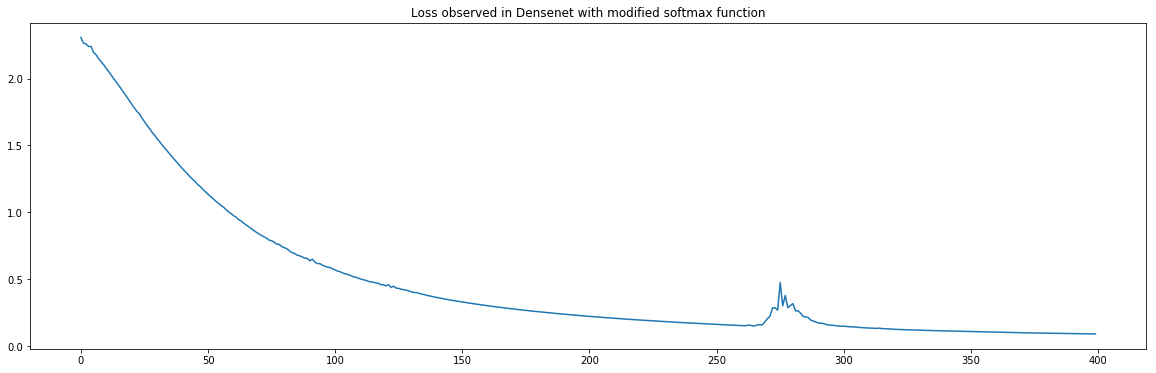

In [70]:
plt.figure(figsize=(20, 6))
plt.plot(np.arange(len(losses)), losses)
plt.title("Loss observed in Densenet with modified softmax function")
plt.show()

-------------------------
# LINCS Dataset Training

In [3]:
data_sub = pd.read_csv('../Data/subset.csv')
data = pickle.load(open('../Data/full', 'rb'))

In [4]:
data.columns

Index(['780', '7849', '6193', '23', '9552', '387', '10921', '10285', '533',
       '6194',
       ...
       '11000', '6915', '6253', '7264', '5467', '2767', '23038', '57048',
       '79716', 'target'],
      dtype='object', name='rid', length=979)

In [5]:
X = data.loc[:, '780':'79716']
y = list(data['target'])
pert_dict = {}
num = 0
for a in range(len(y)):
    if y[a] not in pert_dict.keys():
        pert_dict[y[a]] = num
        num+=1
    y[a] = pert_dict[y[a]]

In [6]:
len(set(data['target']))
len(y)

118050

In [7]:
X = X[:100]
y = np.asarray(y[:100]).flatten()
# y_small

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
input_size = 978
n_layers = 10
n_classes = 2170
n_units = 20
batch_size = 3000
epochs = 10
learning_rate = 0.05

tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, input_size])
original_input = inputs
labels = tf.placeholder(tf.int32, [None])

for a in range(n_layers):
    layer = tf.layers.dense(inputs, n_units, 'selu', name='layer'+str(a))
    inputs = tf.concat([inputs, layer], 1, name='concatenation'+str(a))

logits = tf.layers.dense(inputs, n_classes, None, name='output')
logits = tf.math.l2_normalize(logits, axis=1)

onehot_label = tf.one_hot(labels, n_classes, name='labels_onehot')
loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=onehot_label))

predictions = tf.nn.softmax(logits)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

with tf.Session() as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    dnn_loss = []
    feed_dict={original_input:X_train, labels:y_train}    
    
    total = np.asarray(session.run([original_input], feed_dict=feed_dict)).shape[1]
    order = np.arange(total)

    for a in range(epochs):
        np.random.shuffle(order)
        total_loss = 0
        total_acc = 0
        
        for ind in range(0, total, batch_size):
            sys.stdout.flush()
            perc = math.ceil(50*(ind/total))
            feed_dict[original_input] = X_train.iloc[order[ind:ind+batch_size]]
            feed_dict[labels] = [y_train[a] for a in order[ind:ind+batch_size]]
            _, l, p = session.run([optimizer, loss, predictions], 
                              feed_dict=feed_dict)
            total_loss+=(l)
            total_acc+=(np.sum(np.equal(np.argmax(p, axis=1), feed_dict[labels])))
            sys.stdout.write("\rEpoch %d: \t[%s%s] %d/%d Loss: %f" % (a, "="*perc, ' '*(50-perc), ind, total, total_loss/(ind+batch_size)))
            
        
        dnn_loss.append(total_loss/total)
        sys.stdout.write("\rEpoch %d: \t[%s] %d/%d Loss: %f Accuracy: %.2f%%\n" % (a, "="*50, total, total, total_loss/total, 100*total_acc/total))

    test_p = session.run(predictions, feed_dict={original_input:X_test})
    print("Test Accuracy: ", 100*(np.sum(np.equal(np.argmax(test_p, axis=1), y_test)))/(len(y_test)))

    
    tf.summary.FileWriter('./logs', session.graph)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Epoch 0: 	[==================================================] 70/70 Loss: 7.684961 Accuracy: 0.00%
Epoch 1: 	[==================================================] 70/70 Loss: 7.603830 Accuracy: 75.71%
Epoch 2: 	[==================================================] 70/70 Loss: 7.707685 Accuracy: 1.43%
Epoch 3: 	[==================================================] 70/70 Loss: 7.642804 Accuracy: 48.57%
Epoch 4: 	[==================================================] 70/70 Loss: 7.603243 Accuracy: 65.71%
Epoch 5: 	[==============================

### Densenet with Modified Softmax

In [12]:
input_size = 978
n_layers = 10
n_classes = 2170
n_units = 12
batch_size = 3000
epochs = 50
learning_rate = 0.005

embedding_length = 32
number_of_samples = 300

tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, input_size], name='gene_expression')
original_input = inputs
labels = tf.placeholder(tf.int32, [None], name='labels')

for a in range(n_layers):
    layer = tf.layers.dense(inputs, n_units, 'selu', name='layer'+str(a))
    inputs = tf.concat([inputs, layer], 1, name='concatenation'+str(a))

embeddings = tf.layers.dense(inputs, embedding_length, None, name='embedding')
norm_embeddings = tf.nn.l2_normalize(embeddings, axis=1, name='norm_embeddings')

# class_weights = tf.constant(normalize(np.random.rand(embedding_length, n_classes)), dtype=tf.float32,
#                            name='class_weights')

class_weights = tf.Variable(tf.random_normal([embedding_length, n_classes], stddev=0.35), name="class_weights")

margin = tf.placeholder(tf.float32, name='margin')

alpha_initial = tf.get_variable(dtype=tf.float32, initializer=tf.constant(np.random.rand(1), dtype='float32'), 
                                name='alpha')
alpha = tf.nn.relu(alpha_initial)

cosines = tf.matmul(norm_embeddings, class_weights, name='cosines')
onehot_label = tf.one_hot(labels, n_classes, name='labels_onehot')
m_onehot = tf.math.multiply(margin, onehot_label, name='mxonehot')
margin_cosine = tf.subtract(cosines, m_onehot, name='cosine-m')
alpha_margin_cosine = tf.math.exp(tf.math.multiply(alpha, margin_cosine), name='alphaxc-m')
amc_numerator = tf.reduce_sum(tf.multiply(alpha_margin_cosine, onehot_label), axis=1, name='amc_positive')
amc_denominator = tf.reduce_sum(alpha_margin_cosine, axis=1, name='amc_total')
amc_fraction = tf.divide(amc_numerator, amc_denominator, name='amc_fraction')
log_amcf = -tf.log(amc_fraction, name='log_amc')
loss = tf.reduce_sum(log_amcf, name='loss')

m = 0
m_change = 0.00002
m_max = 25

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [13]:
with tf.Session() as session:
    feed_dict={original_input:np.random.rand(number_of_samples, input_size),
                                     labels: np.random.randint(0, n_classes, number_of_samples),
                                      margin: m}
    
    feed_dict={original_input:X, labels: y, margin: m}
    
    
    alpha_initial.initializer.run()
    tf.initialize_all_variables().run()
    print("Initialized")
    
    total = np.asarray(session.run([original_input], feed_dict=feed_dict)).shape[1]
    order = np.arange(total)
    losses = []
    
    for a in range(epochs):
        np.random.shuffle(order)
        total_loss = 0
        sys.stdout.write("\rEpoch %d: \t[%s%s] %d/%d Loss: %f" % (a, "="*0, ' '*(50), ind, total, 0))
            
        for ind in range(0, total, batch_size):
            sys.stdout.flush()
            perc = math.ceil(50*(ind/total))
            feed_dict[original_input] = X.iloc[order[ind:ind+batch_size]]
            feed_dict[labels] = [y[a] for a in order[ind:ind+batch_size]]
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            sys.stdout.write("\rEpoch %d: \t[%s%s] %d/%d Loss: %f" % (a, "="*perc, ' '*(50-perc), ind, total, total_loss/(ind+batch_size)))
            total_loss+=(l)
            
        sys.stdout.write("\rEpoch %d: \t[%s] %d/%d Loss: %f\n" % (a, "="*50, total, total, total_loss/total))
        losses.append(total_loss/total)
        feed_dict[margin] = min(feed_dict[margin]+m_change, m_max)
    
    tf.summary.FileWriter('./logs', session.graph)
    saver = tf.train.Saver()
    saver.save(session, './models/trial1')

Initialized
Epoch 0: 	[==================================================] 100/100 Loss: 7.696288
Epoch 1: 	[==================================================] 100/100 Loss: 7.323425
Epoch 2: 	[==================================================] 100/100 Loss: 7.196678
Epoch 3: 	[==================================================] 100/100 Loss: 7.141425
Epoch 4: 	[==================================================] 100/100 Loss: 7.097783
Epoch 5: 	[==================================================] 100/100 Loss: 7.053423
Epoch 6: 	[==================================================] 100/100 Loss: 7.011295
Epoch 7: 	[==================================================] 100/100 Loss: 6.973979
Epoch 8: 	[==================================================] 100/100 Loss: 6.941943
Epoch 9: 	[==================================================] 100/100 Loss: 6.913185
Epoch 10: 	[==================================================] 100/100 Loss: 6.884202
Epoch 11: 	[=============================

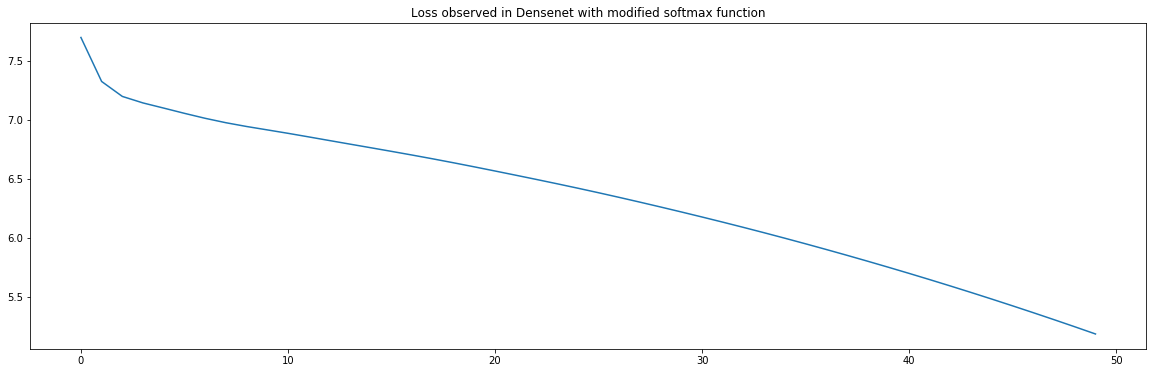

In [14]:
plt.figure(figsize=(20, 6))
plt.plot(np.arange(len(losses)), losses)
plt.title("Loss observed in Densenet with modified softmax function")
plt.show()

In [52]:
# tf.reset_default_graph()
def save_embeddings(X, y, filename):
    with tf.Session() as session:
        saver = tf.train.import_meta_graph('./models/trial.meta')
        saver.restore(session,tf.train.latest_checkpoint('./models/'))
        graph = tf.get_default_graph()
        original_input = graph.get_tensor_by_name('gene_expression:0')
        norm_embeddings = graph.get_tensor_by_name('norm_embeddings:0')
        print(original_input)
        print("Loaded")
        feed_dict={original_input:np.asarray(X)}
        embeddings = pd.DataFrame(session.run([norm_embeddings], feed_dict=feed_dict)[0],
                                  columns=['e'+str(a) for a in range(1, 33)])
        embeddings['target'] = y
        pickle.dump(embeddings, open(filename, 'wb'))
        

In [54]:
save_embeddings(X, y, './embeddings/emb50all')

INFO:tensorflow:Restoring parameters from ./models/trial
Tensor("gene_expression:0", shape=(?, 978), dtype=float32)
Loaded
